# Task 5 - cell type proportions

In [121]:
import scanpy as sc
import muon as mu
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

In [44]:
mdata = mu.read('task5_input.h5mu')

In [48]:
mdata.obs['pSS'] = mdata.obs['pSS'].apply(lambda x: 'pSS' if x == 1 else 'HC')

In [49]:
sc.tl.embedding_density(mdata, groupby='pSS')

/home/ssm-user/miniconda3/envs/single_cell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


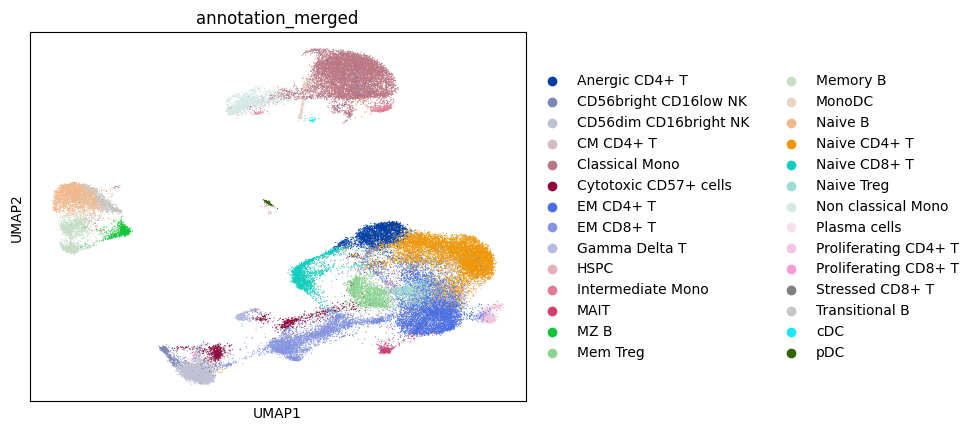

In [54]:
sc.pl.umap(mdata, color='annotation_merged')

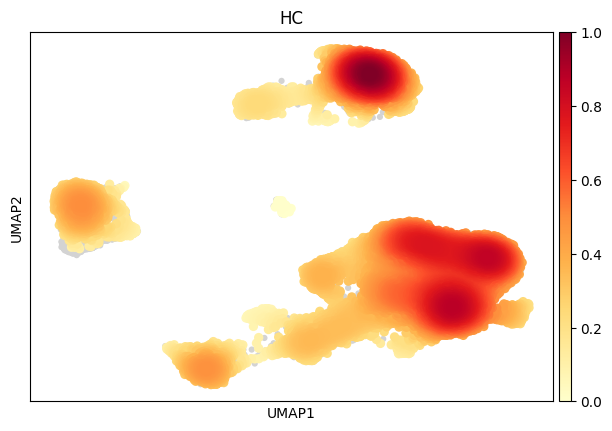

In [60]:
sc.pl.embedding_density(mdata, groupby='pSS', group='HC')

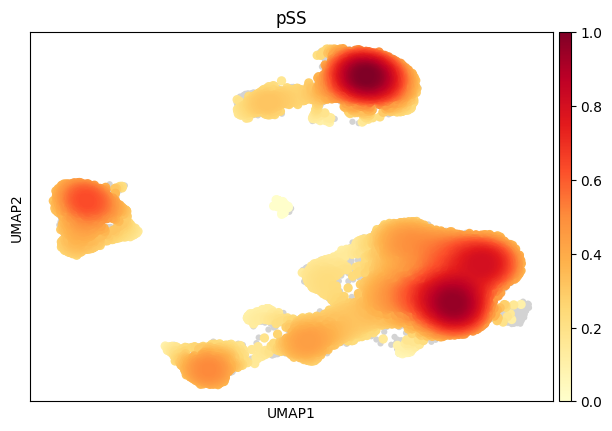

In [59]:
sc.pl.embedding_density(mdata, groupby='pSS', group='pSS')

### Cell type proportions

In [97]:
counts

,annotation_merged,siccaid,count
0,Proliferating CD4+ T,10101200,621
1,Classical Mono,10189800,459
2,Memory B,10108000,442
3,Classical Mono,10206800,426
4,Classical Mono,10101400,412
...,...,...,...
1078,Transitional B,10204400,1
1079,Proliferating CD4+ T,10104700,1
1080,Proliferating CD4+ T,10149200,1
1081,Proliferating CD4+ T,10209000,1


In [96]:
counts = mdata.obs[['annotation_merged', 'siccaid']].value_counts().reset_index()

0       0.669903
1       0.341772
2       0.491111
3       0.343272
4       0.230683
          ...   
1078    0.000867
1079    0.000882
1080    0.003185
1081    0.000770
1082    0.001129
Name: count, Length: 1083, dtype: float64

In [111]:
hc_list = mdata.obs.query('pSS == "HC"').siccaid.drop_duplicates().tolist()

ct_list = mdata.obs.annotation_merged.drop_duplicates().tolist()

counts = mdata.obs[['annotation_merged', 'siccaid']].value_counts().reset_index()
counts['freq'] = counts.groupby('siccaid')['count'].transform(lambda x: x/x.sum())
counts['pSS'] = counts['siccaid'].apply(lambda x: 'HC' if x in hc_list else 'pSS')

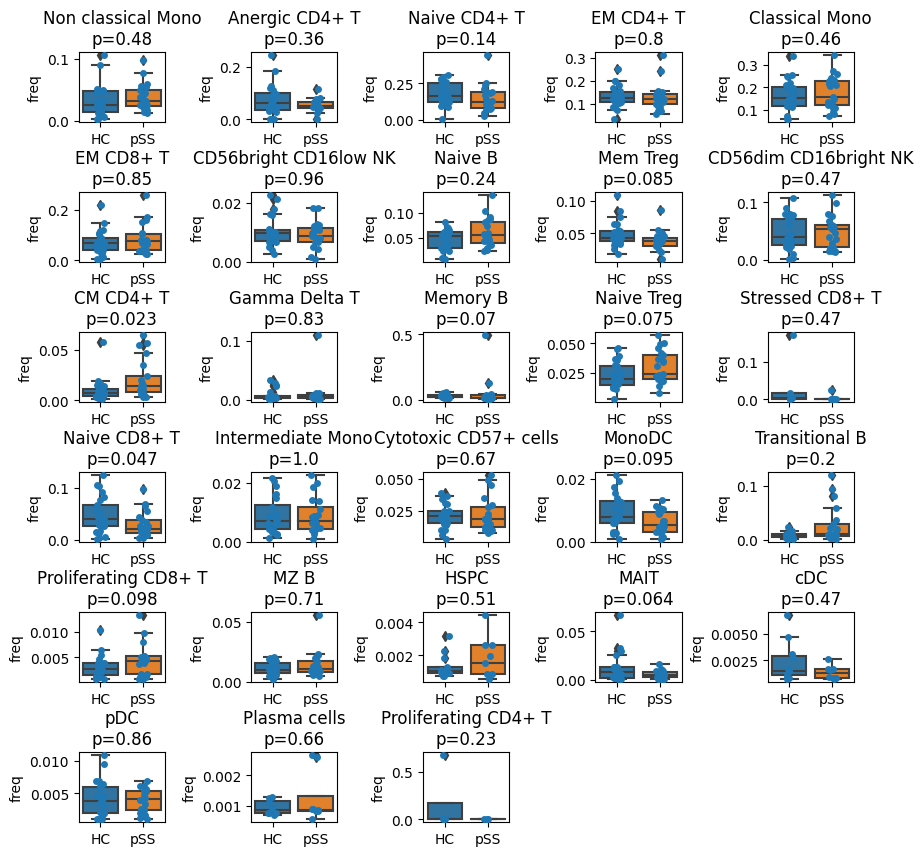

In [172]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=1, hspace=1)

for idx, ct in enumerate(ct_list):
    ct_freqs = counts.query(f'annotation_merged == "{ct}"').sort_values('fs_score')

    _, pv = stats.ks_2samp(
        ct_freqs.query('pSS == "pSS"').freq,
        ct_freqs.query('pSS == "HC"').freq)

    plt.subplot(6, 5, idx+1)
    sns.stripplot(x='pSS', y='freq', data=ct_freqs)
    sns.boxplot(x='pSS', y='freq', data=ct_freqs)
    plt.title(f'{ct}\np={pv:.2}')    
    plt.xlabel('')
plt.savefig('disease_ct_proportion_differences.png')
    

### Focal score

In [154]:
def classify(x):

    if x in hc_list:
        return -1
    elif x in fs_list:
        return 1
    else:
        return 0

In [155]:
hc_list = mdata.obs.query('pSS == "HC"').siccaid.drop_duplicates().tolist()

ct_list = mdata.obs.annotation_merged.drop_duplicates().tolist()

fs_list = mdata.obs.query('pSS == "pSS" & fs > 0').siccaid.drop_duplicates().tolist()

counts = mdata.obs[['annotation_merged', 'siccaid']].value_counts().reset_index()

counts['freq'] = counts.groupby('siccaid')['count'].transform(lambda x: x/x.sum())

counts['pSS'] = counts['siccaid'].apply(lambda x: 'HC' if x in hc_list else 'pSS')

counts['fs_score'] = counts['siccaid'].apply(classify)

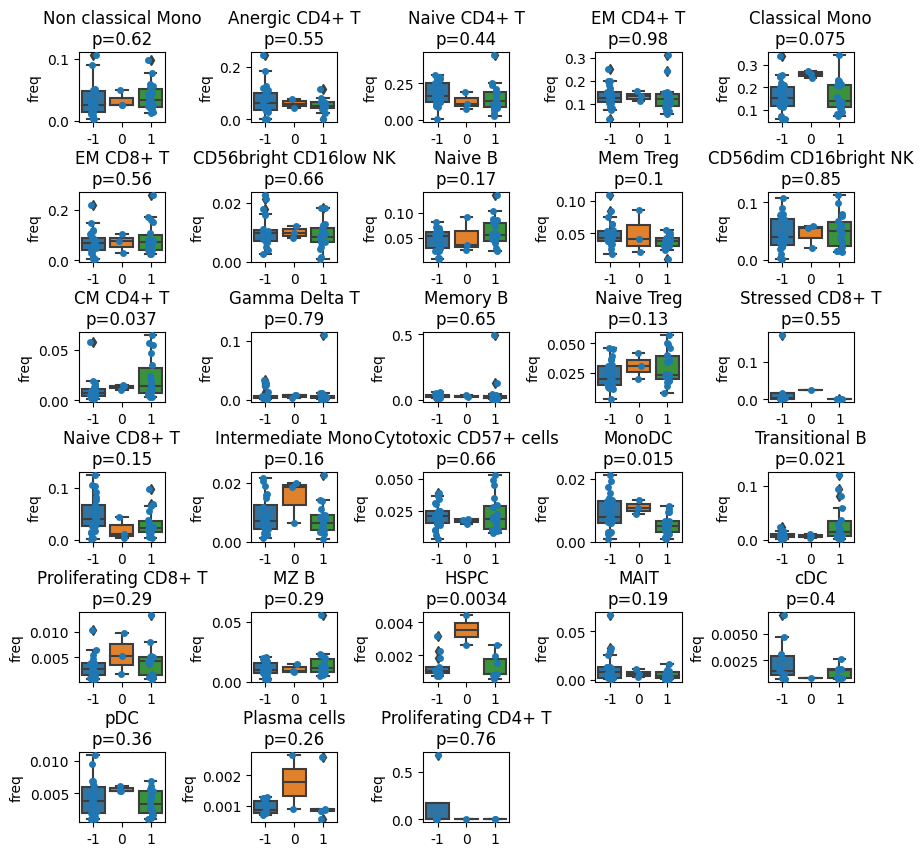

In [173]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=1, hspace=1)

for idx, ct in enumerate(ct_list):
    ct_freqs = counts.query(f'annotation_merged == "{ct}"').sort_values('fs_score')

    _, pv = stats.f_oneway(
        ct_freqs.query('fs_score == -1').freq,
        ct_freqs.query('fs_score == 0').freq,
        ct_freqs.query('fs_score == 1').freq)

    plt.subplot(6, 5, idx+1)
    sns.stripplot(x='fs_score', y='freq', data=ct_freqs, s=5)
    sns.boxplot(x='fs_score', y='freq', data=ct_freqs)
    plt.title(f'{ct}\np={pv:.2}')    
    plt.xlabel('')
plt.savefig('fs_ct_proportion_differences.png')
    

In [70]:
mdata.obs['annotation_merged'].value_counts()

annotation_merged
Classical Mono           8449
Naive CD4+ T             7577
EM CD4+ T                6317
EM CD8+ T                3762
Anergic CD4+ T           2559
Naive B                  2497
CD56dim CD16bright NK    2282
Mem Treg                 2075
Naive CD8+ T             1902
Non classical Mono       1739
Memory B                 1605
Naive Treg               1276
Cytotoxic CD57+ cells    1046
Transitional B            755
CM CD4+ T                 723
Proliferating CD4+ T      627
MZ B                      587
CD56bright CD16low NK     457
MAIT                      424
Gamma Delta T             415
Intermediate Mono         406
MonoDC                    364
Stressed CD8+ T           235
pDC                       190
Proliferating CD8+ T      151
cDC                        43
HSPC                       35
Plasma cells               20
Name: count, dtype: int64

In [61]:
mdata

MuData object with n_obs × n_vars = 48518 × 16663
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'siccaid', 'pSS', 'ssa', 'annotation_merged', 'percent.mt', 'percent.ribo', 'PoolID', 'nCount_ADT', 'nFeature_ADT', 'age', 'sex', 'b_tobacco', 'ssb', 'fs', 'fs_detailed', 'b_lymphoma', 'b_systinvol', 'immune_meds', 'lympho', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters', 'is_pSS', 'umap_density_pSS'
  var:	'features'
  uns:	'annotation_merged_colors', 'umap_density_pSS_params'
  obsm:	'X_umap'
  2 modalities
    rna:	48518 x 16524
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'siccaid', 'pSS', 'ssa', 'annotation_merged', 'percent.mt', 'percent.ribo', 'PoolID', 'nCount_ADT', 'nFeature_ADT', 'age', 'sex', 'b_tobacco', 'ssb', 'fs', 'fs_detailed', 'b_lymphoma', 'b_systinvol', 'immune_meds', 'lympho', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters'
      var:	'features'
      obsm:	'X_harmony', 'X_pca', 'X_umap'
    prot:	48518 x 139
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'siccaid', 'pSS', 'ssa', 'annotation_merged', 'percent.mt', 'percent.ribo', 'PoolID', 'nCount_ADT', 'nFeature_ADT', 'age', 'sex', 'b_tobacco', 'ssb', 'fs', 'fs_detailed', 'b_lymphoma', 'b_systinvol', 'immune_meds', 'lympho', 'RNA.weight', 'ADT.weight', 'wsnn_res.2', 'seurat_clusters'
      var:	'features'
      obsm:	'X_harmony', 'X_pca', 'X_umap'